<a href="https://colab.research.google.com/github/bearbearyu1223/Graph-Neural-Network-Study-Notes/blob/main/heterogeneous_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heterogeneous Graph 

An example of a **homogeneous graph** is an online social network with nodes representing people and edges representing friendship, where **the type of nodes and edges are always the same**. On the other hand, a graph with two or more types of node and/or two or more types of edge is called **heterogeneous**.

## Setup

In [1]:
import torch 
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [2]:
!nvcc --version
!python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
11.8


In [3]:
import torch_geometric
print("PyG version :{}".format(torch_geometric.__version__))

PyG version :2.4.0


## DeepSNAP Heterogenous Graph
[DeepSNAP](https://github.com/snap-stanford/deepsnap) extends its traditional graph representation to include heterogenous graphs by including the following graph property features: 


* node_feature: The feature of each node 
* edge_feature: The feature of each edge
* node_label: The label of each node
* node_type: The type of each node
* edge_type: The type of each eadge



In [4]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt 
import copy
from pylab import show

###  Karate Club Graph
Each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer").

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


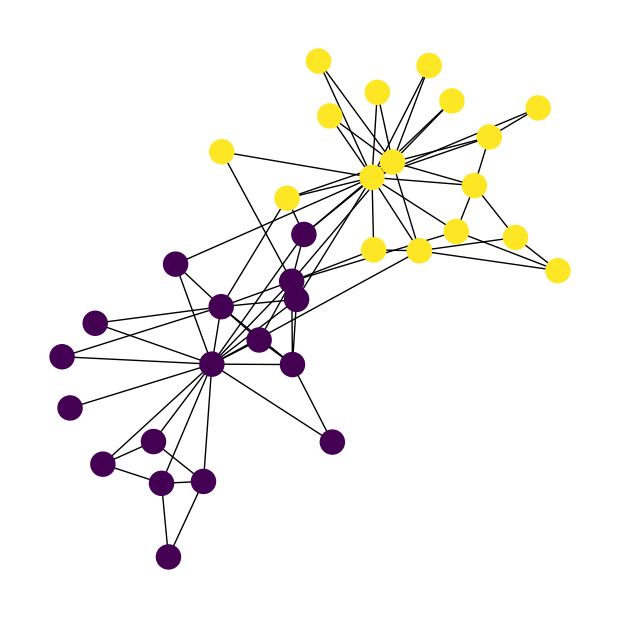

In [5]:
G = nx.karate_club_graph()
print(G.nodes(data=True)) # Task a look at the data in the graph
community_map = {}
for node in G.nodes(data=True): 
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0  
  else: 
    community_map[node[0]] = 1
node_color = []
color_map = {0:0, 1:1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos, cmap=plt.get_cmap("viridis"), node_color = node_color)
show()

### Assign Node Type and Node Features 

For `node_type`, assign nodes in the "Mr.Hi" club to a node type `n0` and nodes in "Officer" club a node type `n1`. 

For `node_label`, assigne nodes in the "Mr.Hi" club to a `0` and nodes in the "Office" club to a `1`. 

Assign every node the tensor feature vector `[1, 1, 1, 1, 1]`. 

In [6]:
def assign_node_types(G, community_map): 
  values = {}
  for node in G.nodes(data=True): 
    if community_map[node[0]] == 0:
      values[node[0]] = "n0"
    else: 
      values[node[0]] = "n1"
  nx.classes.function.set_node_attributes(G, values, name="node_type")

def assign_node_labels(G, community_map): 
  nx.classes.function.set_node_attributes(G, community_map, name="node_label")

def assign_node_features(G): 
  nx.classes.set_node_attributes(G, [1.0, 1.0, 1.0, 1.0, 1.0], name="node_feature")

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

node_id = 0
print("Node {} has properties {}".format(node_id, G.nodes(data=True)[node_id]))

Node 0 has properties {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


### Assign Edge Types


* Edges with club "Mr.Hi": `e0`
* Edges with club "Officer": `e1`
* Edges between the two clubs: `e2`

In [7]:
def assign_edge_types(G, community_map): 
  values = {}
  for edge in G.edges(data=True):
    if community_map[edge[0]] == 0 and community_map[edge[1]] == 0:
      values[(edge[0], edge[1])] = "e0"
    elif community_map[edge[0]] == 1 and community_map[edge[1]] == 1:
      values[(edge[0], edge[1])] = "e1"
    else:
      values[(edge[0], edge[1])] = "e2"
  nx.classes.function.set_edge_attributes(G, values, name="edge_type")

assign_edge_types(G, community_map)
edge_idx = 15
n1 = 0
n2 = 31
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


### Visualize the Heterogenos Graph 

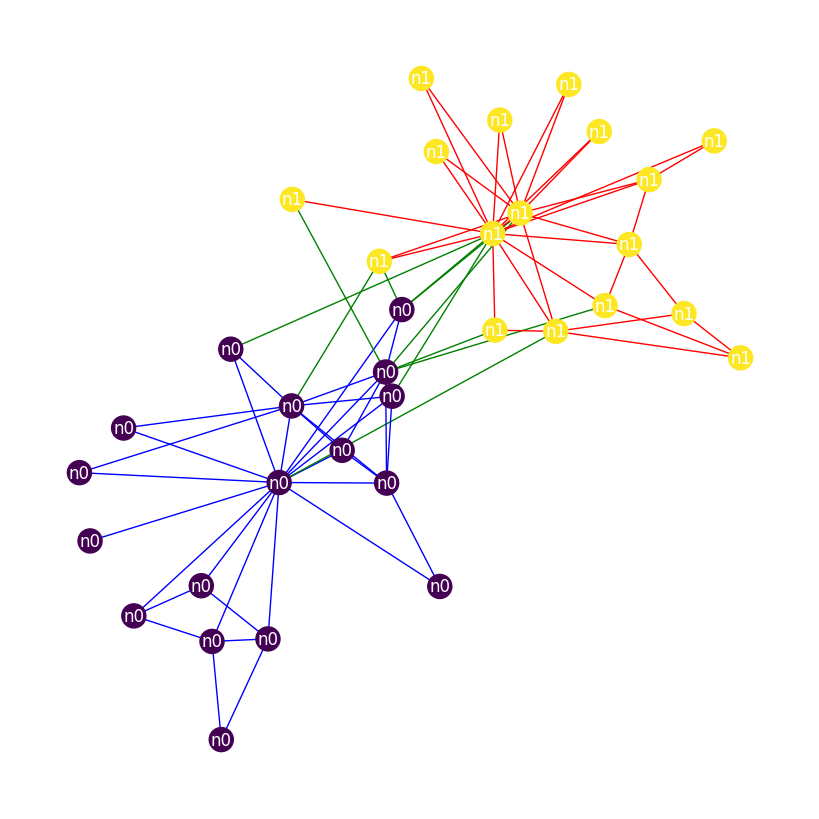

In [8]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
  if community_map[n1] == community_map[n2] and community_map[n1] == 0:
    edge_color[edge] = 'blue'
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  else:
    edge_color[edge] = 'green'
G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('viridis'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

### Transform the NetworkX Graph to DeepSNAP Graph Representation

In [9]:
from deepsnap.hetero_graph import HeteroGraph
hete = HeteroGraph(G_orig)

In [10]:
def get_nodes_per_type(hete): 
  num_nodes_n0 = hete.num_nodes("n0") 
  num_nodes_n1 = hete.num_nodes("n1")
  return num_nodes_n0, num_nodes_n1

In [11]:
num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node Type n0 has {} nodes".format(num_nodes_n0))
print("Node Type n1 has {} nodes".format(num_nodes_n1))

Node Type n0 has 17 nodes
Node Type n1 has 17 nodes


In [12]:
def get_num_message_edges(hete):
  message_type_edges = []
  for message_type in hete.message_types:
    message_type_edges.append([message_type, hete.num_edges(message_type=message_type)])
  return message_type_edges

In [13]:
message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
  print("Message type {} has {} edges".format(message_type, num_edges)) 

Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


### Dataset Spliting and Visualization
Split the dataset into train, validation and test dataset, and visulize the nodes in each of the dataset. 

In [14]:
def compute_dataset_split_counts(datasets): 
  data_set_splits = {}
  for split in datasets.keys():
    data_set_splits[split] = len(datasets[split][0].node_label_index["n0"]) + len(datasets[split][0].node_label_index["n1"])
  return data_set_splits

In [15]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task="node")
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio = [0.4, 0.3, 0.3])
datasets = {"train": dataset_train, "val": dataset_val, "test": dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items(): 
  print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


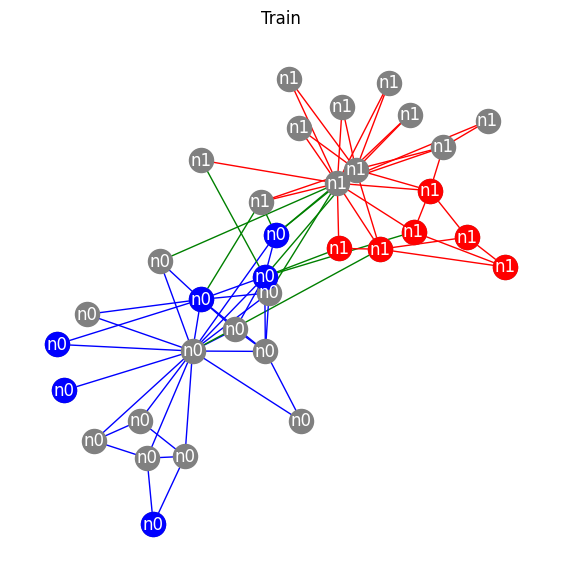

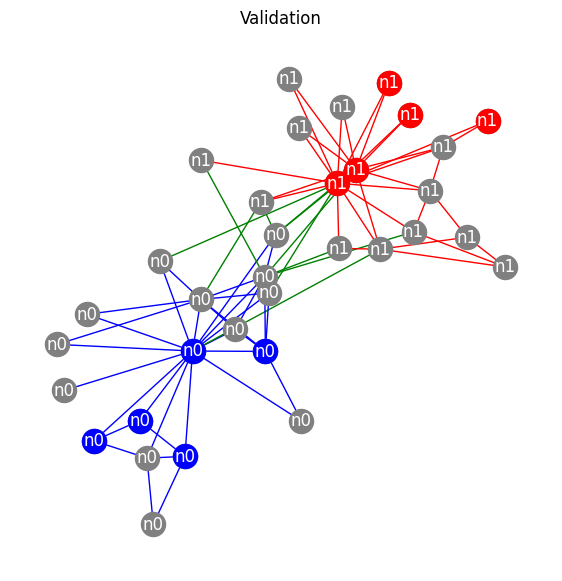

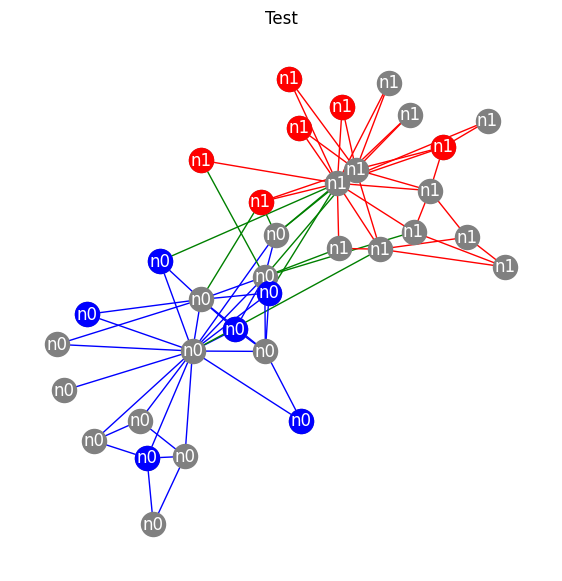

In [16]:
titles = ["Train", "Validation", "Test"]
for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

## Heterogeneous Graph Node Property Prediction 

Let us assume we have a Graph `G`, which contains two node types `a` and `b`, and three message types $m_1 = (a, r_1, a)$, $m_2 = (a, r_2, b)$, and $m3 = (a, r_3, b)$. We view each message as (src, relation, dst), where messages "flow" from src to dst node types. 

When applying message passing in heterogenous graphs, we separately apply message passing over each message type (e.g., updating node type `b` relies on two different message types $m_2$ and $m_3$). For the graph `G`, a heterogeneous GNN layer contains three seperate Heterogenous Message Passing Layer (since we have 3 different message types), where each `HeteroGNNConv` layer performs messaging passing and aggregation with repsect to only one message type. Since a message type is viewed as (src, relation, dst) and meassges "flow" from src to dst, each `HeteroGNNConv` layer only computes embeddings for the dst nodes of a give message type. For example, the `HeteroGNNConv` layer for messaging type $m_2$ outputs updated embedding representations only for node's with type `b`. 

Since each `HeteroGNNConv` is only applied over a single message type, we additionaly define a Heterogeneous GNN Wrapper layer (`HeteroGNNWrapperConv`). This wrapper manages and combines the output each `HeteroGNNConv` layer in order to generate the complete updated node embeddings for each node type in layer `l` of our model. More specifically, the $l^{th}$ `HeteroGNNWrapperConv` layer takes as input the node embeddings computed for each message type and node type (e.g., $H_b^{(l)[m_2]}$, $H_b^{(l)[m_3]}$) and aggregate across message types with the same dst node type. The resulting output of the $l^{th}$ `HeteroGNNWrapperConv` layer is the updated embedding matrix $H^{l}_i$ for each node type $i$. 

### Import Relevant Libraries 

In [17]:
import copy
import torch
import deepsnap
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul 

### Dataset 

In [18]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [19]:
id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('acm.pkl')

### Impletement the `HeteroGNNConv` Layer
At a high-level, the `HeteroGNNConv` layer is equivalent to the homogenous GNN layers, but now applied to an individual heterogeous message type. Moreover, our heterogenous GNN layer draws directly from the *GraphSAGE* message passing model introduced in ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

Define the `HeteroGNNConv` layer with respect to message type `m`:

$\begin{equation} m = (s, r, d)\end{equation}$

where each message type is a tuple containing three elements: 
* $s$- the source node type
* $r$- the edge(relation) type
* $d$- the destination node type

The message passing update rule is very similar to that of *GraphSAGE*, except we now need to include the node types and the edge relation type. The update rule for messaging type $m$ is described below: 

$\begin{equation}
h^{(l)[m]}_{v} = W^{(l)[m]}· CONCAT\big( W^{(l)[m]}_d\cdot h^{l-1}_v, W^{(l)[m]}_s\cdot AGG(\{h^{l-1}_u, \forall u \in N_m(v)\})\big)
 \end{equation}$

 Where
 * $h^{(l)[m]}_{v}$ is the node embedding representation for node $v$ after `HeteroGNNConv` layer `l` with respect to message type `m`. 
 * $W^{(l)[m]}_d$ is the linear transformation matrix for the message from the node `v` itself along message type `m `. 
 * $W^{(l)[m]}_s$ is the linear transformation matrix for the messages of neighboring source nodes `s` along message type `m`. 
 * $W^{(l)[m]}$ is the linear transformation matrix for the concatenated messages from neighboring nodes and the center node. 
 * $h^{l-1}_u$ is the hidden embedding representation for the node `u` after the $(l-1)^{th}$ `HeteroGNNWrapperConv` layer.
 * $N_m(v)$ is the set of neighbor source nodes `s` for the node `v` that we are embeding along message type `m = (s, r, d)`. 

**Note**: each weight/linear transformation matrix listed above is associated with a specific message type `[m]` and additionally, the matrix applied to node messages are differentiated by node type (e.g., $W^{(l)[m]}_d$ and $W^{(l)[m]}_s$). 

 Lastfly, we will use mean aggregation for `AGG` where

 $\begin{equation}
 AGG(\{h^{l-1}_u, \forall u \in N_m(v)\}) = \frac{1}{|N_m(v)|}\sum_{u\in N_m(v)}h^{(l-1)}_u
 \end{equation}$   




In [20]:
class HeteroGNNConv(pyg_nn.MessagePassing):
  def __init__(self, in_channels_src, in_channels_dst, out_channels): 
    super().__init__(aggr="mean")

    self.in_channels_src = in_channels_src
    self.in_channels_dst = in_channels_dst
    self.out_channels = out_channels

    self.lin_dst = nn.Linear(self.in_channels_src, self.out_channels)
    self.lin_src = nn.Linear(self.in_channels_dst, self.out_channels)
    self.lin_update = nn.Linear(2 * self.out_channels, self.out_channels)
  
  def forward(self, node_feature_src, node_feature_dst, edge_index, size=None):
    return self.propagate(
        edge_index = edge_index, 
        node_feature_src = node_feature_src, 
        node_feature_dst= node_feature_dst, 
        size = size, 
        res_n_id = None, 
    )
  
  def message_and_aggregate(self, edge_index, node_feature_src):
    out = matmul(edge_index, node_feature_src, reduce="mean")
    return out

  def update(self, aggr_out, node_feature_dst): 
    dst_out = self.lin_dst(node_feature_dst)
    aggr_out = self.lin_src(aggr_out)
    aggr_out = torch.cat([dst_out, aggr_out], -1)
    aggr_out = self.lin_update(aggr_out)
    return aggr_out


### Implement `HeterogenousCNNWraper` Layer

After implementing the `HeteroGNNConv` layer for each message type, we need to aggregate the node embedding results with respect to each message type for each node. 

The first approach is simply `mean` aggregation over message types: 

$\begin{equation}h^{l}_v = \frac{1}{M}\sum_{m=1}^{M}h^{(l)[m]}_v\end{equation}$

The second approach is semantic level attention introduced in ([Wang et al.(2019)](https://arxiv.org/abs/1903.07293)), which use attention to learn which message type result is more important, then aggregate across all the message types: 

$\begin{equation}e_m = \frac{1}{V_d}\sum_{v\in V_d}q^{(l)T}_{attn}\cdot tanh\big(W^{(l)}_{attn}\cdot h^{(l)[m]}_v +b\big)\end{equation}$

where the unnormalized attention weight $e_m$ is a scalar computed fro each message type $m$, which can be further used to compute the normalized attention weights and update $h^{(l)}_v$:

$\begin{equation}\alpha_m = \frac{exp(e_m)}{\sum_{m=1}^{M}exp(e_m)}\end{equation}$

$\begin{equation}h^{(l)}_v = \sum_{m=1}^{M}\alpha_m \cdot h^{(l)[m]}\end{equation}$

In [21]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
  def __init__(self, convs, args, aggr=None):
    super(HeteroGNNWrapperConv, self).__init__(convs, None)
    self.aggr = aggr
    
    self.mapping = {}

    self.alpha = None

    self.attn_proj = None

    if self.aggr == "attn":
        self.attn_proj = nn.Sequential(
            nn.Linear(args["hidden_size"], args["attn_size"]),
            nn.Tanh(),
            nn.Linear(args["attn_size"], 1, bias=False),
        )
  
  def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()

  def forward(self, node_features, edge_indices):
      message_type_emb = {}
      for message_key, message_type in edge_indices.items():
          src_type, edge_type, dst_type = message_key
          node_feature_src = node_features[src_type]
          node_feature_dst = node_features[dst_type]
          edge_index = edge_indices[message_key]
          message_type_emb[message_key] = self.convs[message_key](
              node_feature_src,
              node_feature_dst,
              edge_index,
          )
      node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
      mapping = {}
      for (src, edge_type, dst), item in message_type_emb.items():
          mapping[len(node_emb[dst])] = (src, edge_type, dst)
          node_emb[dst].append(item)
      self.mapping = mapping
      for node_type, embs in node_emb.items():
          if len(embs) == 1:
              node_emb[node_type] = embs[0]
          else:
              node_emb[node_type] = self.aggregate(embs)
      return node_emb

  def aggregate(self, xs):
        N = xs[0].shape[0]  # Number of nodes for the given node type
        M = len(xs)  # Number of message types for the given node type

        if self.aggr == "mean":
            xs = torch.stack(xs)
            out = torch.mean(xs, dim=0)
            return out

        elif self.aggr == "attn":
            xs = torch.stack(xs, dim=0)
            s = self.attn_proj(xs).squeeze(-1)
            s = torch.mean(s, dim=-1)
            self.alpha = torch.softmax(s, dim=0).detach()
            out = self.alpha.reshape(-1, 1, 1) * xs
            out = torch.sum(out, dim=0)
            return out

In [22]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
  
    convs = {}
    all_messages_types = hetero_graph.message_types
    for message_type in all_messages_types:
        if first_layer:
            in_channels_src = hetero_graph.num_node_features(message_type[0])
            in_channels_dst = hetero_graph.num_node_features(message_type[2])
        else:
            in_channels_src = hidden_size
            in_channels_dst = hidden_size
        out_channels = hidden_size
        convs[message_type] = conv(in_channels_src, in_channels_dst, out_channels)
    return convs

### HeteroGNN

Make a simple `HeteroGNN` model which contains only two `HeteroGNNWrapperConv` layers. 

For the forward function in `HeteroGNN`, the model is going to be ran as: 

self.convs1-> self.bns1-> self.relus1 -> self.convs2 -> self.bns2 -> self.relus2 -> self.post_mps

In [23]:
class HeteroGNN(torch.nn.Module):
  def __init__(self, hetero_graph, args, aggr="mean"):
    super(HeteroGNN, self).__init__()
    
    self.aggr = aggr 
    self.hidden_size = args["hidden_size"]

    self.convs1 = HeteroGNNWrapperConv(
            generate_convs(
                hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True
            ),
            args,
            self.aggr,
        )
    self.convs2 = HeteroGNNWrapperConv(
            generate_convs(
                hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False
            ),
            args,
            self.aggr,
        )
    self.bns1 = nn.ModuleDict()
    self.bns2 = nn.ModuleDict()
    self.relus1 = nn.ModuleDict()
    self.relus2 = nn.ModuleDict()
    self.post_mps = nn.ModuleDict()

    all_node_types = hetero_graph.node_types
    for node_type in all_node_types:
        self.bns1[node_type] = nn.BatchNorm1d(self.hidden_size, eps=1.0)
        self.bns2[node_type] = nn.BatchNorm1d(self.hidden_size, eps=1.0)
        self.relus1[node_type] = nn.LeakyReLU()
        self.relus2[node_type] = nn.LeakyReLU()
        self.post_mps[node_type] = nn.Linear(
            self.hidden_size, hetero_graph.num_node_labels(node_type)
        )

  def forward(self, node_feature, edge_index): 
    x = node_feature 
    x = self.convs1(x, edge_index)
    x = forward_op(x, self.bns1)
    x = forward_op(x, self.relus1)
    x = self.convs2(x, edge_index)
    x = forward_op(x, self.bns2)
    x = forward_op(x, self.relus2)
    x = forward_op(x, self.post_mps)
    return x

  def loss(self, preds, y, indices):
    loss = 0
    loss_func = F.cross_entropy

    for node_type in preds:
        idx = indices[node_type]
        loss += loss_func(preds[node_type][idx], y[node_type][idx])
    return loss

### Training and Testing 

In [24]:
import pandas as pd


def train(model, optimizer, hetero_graph, train_idx):
  model.train()
  optimizer.zero_grad()
  preds = model(hetero_graph.node_feature, hetero_graph.edge_index)
  loss = model.loss(preds, hetero_graph.node_label, train_idx)
  loss.backward()
  optimizer.step()
  return loss.item()


def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
  model.eval()
  accs = []
  for i, index in enumerate(indices):
    preds = model(graph.node_feature, graph.edge_index)
    num_node_types = 0
    micro = 0
    macro = 0
    for node_type in preds:
      idx = index[node_type]
      pred = preds[node_type][idx]
      pred = pred.max(1)[1]
      label_np = graph.node_label[node_type][idx].cpu().numpy()
      pred_np = pred.cpu().numpy()
      micro = f1_score(label_np, pred_np, average="micro")
      macro = f1_score(label_np, pred_np, average="macro")
      num_node_types += 1

    micro /= num_node_types
    macro /= num_node_types
    accs.append((micro, macro))

    if save_preds and i == 2:
      print(
              "Saving Heterogeneous Node Prediction Model Predictions with Agg:",
              agg_type,
          )
      print()

      data = {}
      data["pred"] = pred_np
      data["label"] = label_np

      df = pd.DataFrame(data=data)    
      df.to_csv("ACM-Node-" + agg_type + "Agg.csv", sep=",", index=False)

  if accs[1][0] > best_val:
    best_val = accs[1][0]
    best_model = copy.deepcopy(model)
  return accs, best_model, best_val

In [25]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

In [26]:
def set_seed(seed=224):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False

In [27]:
print("Device: {}".format(args['device']))

set_seed()

# Load the data
data = torch.load("acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cuda
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991], device='cuda:0'),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022], device='cuda:0'),
             size=(3025, 3025), nnz=2207736, density=24.13%)


#### Train and Test using the `Mean` Aggregation

In [28]:
best_model = None
best_val = 0

set_seed()

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Mean")
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.10178, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.09279, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 3: loss 1.06362, train micro 85.33%, train macro 85.61%, valid micro 77.33%, valid macro 77.21%, test micro 63.34%, test macro 62.19%
Epoch 4: loss 1.00446, train micro 79.17%, train macro 77.13%, valid micro 76.33%, valid macro 73.73%, test micro 64.28%, test macro 58.73%
Epoch 5: loss 0.90438, train micro 73.33%, train macro 68.16%, valid micro 70.33%, valid macro 63.67%, test micro 66.21%, test macro 56.95%
Epoch 6: loss 0.76363, train micro 70.5%, train macro 63.09%, valid micro 67.67%, valid macro 58.37%, test micro 65.84%, test macro 55.33%
Epoch 7: loss 0.60616, train micro 70.17%, train macro 62.44%, valid micro 67.33%, valid macro 57.23%, test micro 65.74%, test macro 54.94%
Epoch 8: loss 0.46308, 

#### Train and Test using the `Attention` Aggregation 

In [29]:
best_model = None
best_val = 0

set_seed()

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Attention")
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.09868, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 2: loss 1.09268, train micro 35.5%, train macro 21.01%, valid micro 33.33%, valid macro 16.67%, test micro 35.95%, test macro 17.9%
Epoch 3: loss 1.07108, train micro 65.33%, train macro 54.49%, valid micro 64.0%, valid macro 53.59%, test micro 63.11%, test macro 52.99%
Epoch 4: loss 1.0267, train micro 66.33%, train macro 55.37%, valid micro 66.33%, valid macro 55.31%, test micro 65.18%, test macro 54.42%
Epoch 5: loss 0.94734, train micro 67.17%, train macro 56.73%, valid micro 66.33%, valid macro 55.22%, test micro 65.27%, test macro 54.41%
Epoch 6: loss 0.82333, train micro 67.67%, train macro 57.74%, valid micro 66.67%, valid macro 55.96%, test micro 65.46%, test macro 54.6%
Epoch 7: loss 0.6575, train micro 69.67%, train macro 61.69%, valid micro 67.0%, valid macro 56.68%, test micro 65.55%, test macro 54.62%
Epoch 8: loss 0.47654, trai

## Neighbor Sampling 

Neighbor Sampling, originally proposed in [GraphSAGE](https://arxiv.org/abs/1706.02216) is a representative method to scale up GNNs: rather than loading the entire graph into memory for each training loop, we can instead sample a mini-batch of the nodes and only load the K-hop graph neighborhoods; in this way, we can take advantage of the fact that the embedding of a node `u` only depends on its K-hop neighborgood; to further reduce the memory footprint and computational cost, we can choose to sample only a subset of a node's neighborhood during message passing and aggregation. 